In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import glob 
import os 
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.metrics import make_scorer
# import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split

# Make NumPy printouts easier to read.
np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

2.10.0


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
DATASET_CALOSC=pd.read_csv('../Dane/pogoda/Obrobione.csv')
DATASET_CALOSC=DATASET_CALOSC.drop(['przekaźnik pokojowy','praca_pieca','temperatura wewnętrzna na kominku','temperatura wewnętrzna nad kuchenką gazową'],axis=1)

temp_set = np.concatenate([
    np.full(360, 19),      
    np.full(1020, 21),     
    np.full(60, 19)        
])
length = 78098
temp_set = np.tile(temp_set, length // len(temp_set) + 1)
temp_set = temp_set[:length]
data_set_df = pd.DataFrame(temp_set, columns=['Temperatura zadana'])


DATASET_CALOSC_DODATKOWY = pd.concat([data_set_df, DATASET_CALOSC], axis=1)
# DATASET_CALOSC_DODATKOWY =DATASET_CALOSC


In [25]:
x = DATASET_CALOSC_DODATKOWY.iloc[:, :7]  
y =  DATASET_CALOSC_DODATKOWY.iloc[:, 7] 

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x)

In [12]:
def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='linear') 
])
# 
# model = tf.keras.models.Sequential([
#     normalizer,
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1,activation='linear') 
# ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=['mae'])

scheduler = LearningRateScheduler(custom_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
callbacks = [scheduler, tensorboard]

EPOCHS = 50
BATCH_SIZE=32

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
# model.save("../Modele/pogoda/dlugi")
# model.save("../Modele/pogoda/krótki")
# model.save("../Modele/pogoda/krótki_z_dodatkowym")
# model.save("../Modele/pogoda/długi_z_dodatkowym")

Epoch 1/50
1953/1953 [==============================] - 6s 2ms/step - loss: 20.4215 - mae: 2.1191 - lr: 0.0010
Epoch 2/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.1701 - mae: 0.3167 - lr: 0.0010
Epoch 3/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.1395 - mae: 0.2879 - lr: 0.0010
Epoch 4/50
1953/1953 [==============================] - 5s 2ms/step - loss: 0.1264 - mae: 0.2731 - lr: 0.0010
Epoch 5/50
1953/1953 [==============================] - 5s 2ms/step - loss: 0.1181 - mae: 0.2641 - lr: 9.0484e-04
Epoch 6/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.1117 - mae: 0.2561 - lr: 8.1873e-04
Epoch 7/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.1057 - mae: 0.2484 - lr: 7.4082e-04
Epoch 8/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.1017 - mae: 0.2435 - lr: 6.7032e-04
Epoch 9/50
1953/1953 [==============================] - 4s 2ms/step - loss: 0.0983 - mae: 0.2389 - lr: 

In [17]:
model.evaluate(x_test, y_test)

489/489 [==============================] - 1s 2ms/step - loss: 0.0614 - mae: 0.1821


[0.0613681823015213, 0.18209820985794067]

# Permutation Feature Importance

In [143]:
def model_score(x, y):
    return mean_squared_error(y, model.predict(x))

In [144]:
scorer = make_scorer(model_score, greater_is_better=False)

perm = PermutationImportance(model, scoring=scorer, random_state=41).fit(x_test, y_test)


489/489 [==============================] - 1s 1ms/step


In [145]:
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

In [154]:
WEIGHTS=np.array([[19.0281 , 2.0609 , -26.3594  , -20.1344  , 0.0891  ,6.8117,-20.9930],])

WEIGHTS_max = WEIGHTS.max()
WEIGHTS_min = WEIGHTS.min()

WEIGHTS_normalized = (WEIGHTS - WEIGHTS_min) /(WEIGHTS_max -WEIGHTS.min())


print(WEIGHTS_normalized)

[[1.      0.62617 0.      0.13715 0.58273 0.73084 0.11824]]


## Mapa ciepła wag

In [23]:
model = tf.keras.models.load_model("../Modele/Pogoda/długi_z_dodatkowym")

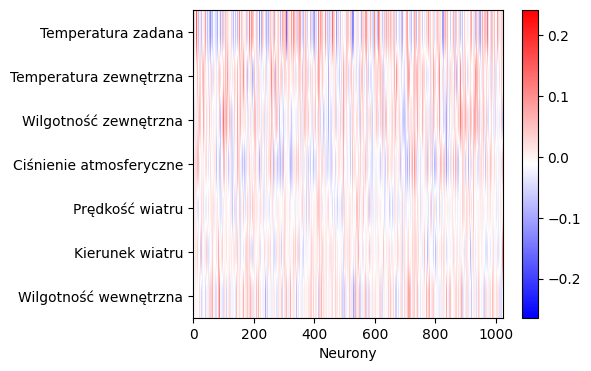

In [26]:
feature_names = x.columns.tolist()
weights = model.layers[1].get_weights()[0]

plt.figure(figsize=(5, 4))
plt.imshow(weights, cmap='bwr', aspect='auto') 
plt.colorbar()  
plt.xlabel('Neurony')
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)
plt.show()

In [29]:
WEIGHTS=np.array([[0., 0., 0., 0., 0., 0.,0.],])

weights=np.abs(weights)
for x in range(7):
    WEIGHTS[0,x]=weights[x,:].mean()

WEIGHTS=np.abs(WEIGHTS)
WEIGHTS_max = WEIGHTS.max()

WEIGHTS_normalized = WEIGHTS /WEIGHTS_max 

print(WEIGHTS_normalized)


[[1.      0.54314 0.61634 0.59913 0.3363  0.34588 0.49053]]


## LIME

In [149]:
train_data = x_train.values

feature_names = x_train.columns.tolist()

explainer = lime.lime_tabular.LimeTabularExplainer(
    train_data, 
    feature_names=feature_names, 
    class_names=['output'], 
    verbose=True, 
    mode='regression'
)

instance = x_test.iloc[453].values

exp = explainer.explain_instance(instance, model.predict, num_features=6)

exp.show_in_notebook(show_table=True, show_all=True)


157/157 [==============================] - 0s 1ms/step
Intercept 22.275284686524834
Prediction_local [141.21557]
Right: 21.813595


In [150]:
WEIGHTS=np.array([[0.06, 0.10, 0.02, 0.03, 0.07,0.05],])

WEIGHTS=np.abs(WEIGHTS)
WEIGHTS_max = WEIGHTS.max()

WEIGHTS_normalized = WEIGHTS /WEIGHTS_max 


print(WEIGHTS_normalized)

[[0.6 1.  0.2 0.3 0.7 0.5]]


In [151]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=x_train.values, 
    feature_names=x_train.columns.tolist(),
    mode='regression'
)

def model_predict(input_data):
    return model.predict(input_data)

num_samples = 100

feature_importances = np.zeros((num_samples, x_train.shape[1]))


for i in range(num_samples):
    random_index = np.random.choice(x_test.shape[0])
    instance = x_train.iloc[random_index].values

    exp = explainer.explain_instance(instance, model_predict, num_features=x_train.shape[1])

    feature_importances[i, :] = [x[1] for x in exp.as_list()]

average_feature_importances = np.mean(feature_importances, axis=0)

print(average_feature_importances)

157/157 [==============================] - 0s 1ms/step
[-66.79228  -0.11489  -0.07794  -0.05221  -0.01065  -0.0018   -0.00943]


In [152]:
average_feature_importances=np.abs(average_feature_importances)

average_feature_importances_norm=average_feature_importances/average_feature_importances.max()
for feature, importance in zip(feature_names, average_feature_importances_norm):
    print(f"{feature}: {importance}")

temperatura_zadana: 1.0
temperatura zewnętrzna: 0.0017200737866988921
wilgotność zewnętrzna: 0.00116697341456642
ciśnienie atmosferyczne: 0.0007816485554823341
prędkość wiatru: 0.00015938017556839582
kierunek wiatru: 2.6879413906674442e-05
wilgotność wewnętrzna: 0.00014118844443655173


INNE

In [153]:
# # Pobranie wag z pierwszej warstwy Dense
# weights = model.layers[1].get_weights()[0]

# colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
#              'Greys', 'Blues', 'BuGn', 'BuPu', 'GnBu', 'OrRd',
#              'PuBuGn', 'coolwarm', 'bwr', 'seismic', 'hot', 'cool',
#              'spring', 'summer', 'autumn', 'winter']

# # Tworzenie subplots
# plt.figure(figsize=(24, 24))  # Zwiększony rozmiar figury

# # Tworzenie kilku subplotów w siatce, w zależności od liczby colormapów
# rows = 5
# columns = 5

# for i, cmap in enumerate(colormaps, start=1):
#     plt.subplot(rows, columns, i)
#     plt.imshow(weights, cmap=cmap, aspect='auto')
#     plt.colorbar()
#     plt.title(f'Mapa ciepła wag pierwszej warstwy Dense - {cmap}')
#     plt.xlabel('Neurony')
#     plt.ylabel('Wejścia')

# plt.tight_layout()
# plt.show()